In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45305")
client

<Client: 'tcp://127.0.0.1:45305' processes=8 threads=40, memory=157.39 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
import xrft
import xwavelet
from scipy.interpolate import interp2d, bisplrep, bisplev, griddata
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
spectre = '/tank/spectre/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA/'
topog = '/tank/topog/tuchida/TWA/'

In [4]:
dsgrd = open_mdsdataset(op.join(ddir,'memb%03d/run%4d/ocn/' 
                                % (100,1967)), 
                        grid_dir=gdir,
                        prefix=['snap_diagOcn'], delta_t=2e2,
                        iters=1419123, 
                       ).isel(time=0)
dsgrd

<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 900, XG: 1000, YG: 900, Z: 46, Zp1: 47, Zu: 46,
              Zl: 46)
Coordinates: (12/33)
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    rhoRef   (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW  (YC, XG) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
Data variables:
    THETA    (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    SALT     (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    UVEL     (Z, YC, XG) >f4 dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    VVEL     (Z, YG, XC) >f4 dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    WVEL     (Zl, YC, XC) >f4 dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [5]:
dsb = xr.open_zarr(op.join(savedir,'Snaps_EnsMean_0001419123.zarr')
                  )

dsb

<xarray.Dataset>
Dimensions:  (YC: 900, XC: 1000, Z: 46, Zp1: 47, XG: 1000, YG: 900, Zl: 46,
              Zu: 46)
Coordinates: (12/33)
    Depth    (YC, XC) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    PHrefC   (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefF   (Zp1) float32 dask.array<chunksize=(47,), meta=np.ndarray>
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * XG       (XG) float32 262.0 262.0 262.1 262.2 ... 347.7 347.8 347.8 347.9
  * YC       (YC) float32 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
    ...       ...
    rA       (YC, XC) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    rAs      (YG, XC) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    rAw      (YC, XG) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    rAz      (YG, XG) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    rhoRef   (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    time     timedelta64[ns] ...
Data variables:
    SALT     (Z, YC, XC) float32 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    THETA    (Z, YC, XC) float32 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    UVEL     (Z, YC, XG) float32 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    VVEL     (Z, YG, XC) float32 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    WVEL     (Zl, YC, XC) float32 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>

In [6]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drF', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
grid = Grid(dsgrd, periodic=['X'], metrics=metrics)
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * outer    Zp1 --> center
  * right    Zu --> center
  * left     Zl --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center

In [7]:
# delta = (grid.derivative(dsb.UVEL.where(dsgrd.maskW!=0.),'X') 
#          + grid.derivative(dsb.VVEL.where(dsgrd.maskS!=0.),'Y',boundary='extend')
#         ).isel(Z=[14,24])
delta = (grid.diff(dsb.UVEL.where(dsgrd.maskW!=0.)*dsgrd.dyG*dsgrd.drF,'X') 
         + grid.diff(dsb.VVEL.where(dsgrd.maskS!=0.)*dsgrd.dxG*dsgrd.drF,'Y',boundary='extend')
        ) / dsgrd.rA/dsgrd.drF
# delta.isel(Z=18).plot(vmax=1e-6)

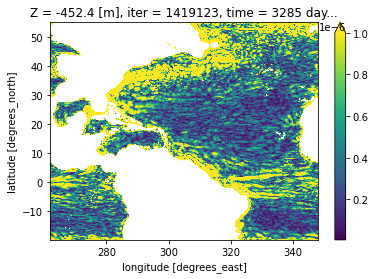

In [8]:
# tmp1 = (grid.derivative(dsb.VVEL.where(dsgrd.maskS!=0.),'Y',boundary='extend') 
#         - grid.derivative(dsb.UVEL.where(dsgrd.maskW!=0.),'X')
#        ).isel(Z=[14,24])**2;
tmp1 = ((grid.diff(dsb.VVEL.where(dsgrd.maskS!=0.)*dsgrd.dxG*dsgrd.drF,'Y',boundary='extend') 
         - grid.diff(dsb.UVEL.where(dsgrd.maskW!=0.)*dsgrd.dyG*dsgrd.drF,'X')
        )/dsgrd.rA/dsgrd.drF)**2;
tmp2 = grid.interp(grid.interp(((grid.diff(dsb.VVEL.where(dsgrd.maskS!=0.) * dsgrd.dyC*dsgrd.drF,'X') 
                                 + grid.diff(dsb.UVEL.where(dsgrd.maskW!=0.) * dsgrd.dxC*dsgrd.drF,'Y',boundary='extend')
                                )/dsgrd.rAz/dsgrd.drF)**2,'X'),
                   'Y',boundary='extend')
alpha = np.sqrt(tmp1 + tmp2)
alpha.isel(Z=18).plot(vmax=1e-6)

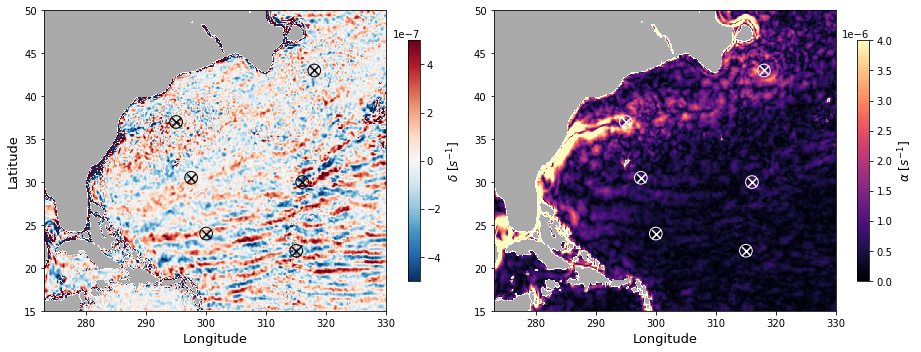

In [10]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

fig, (ax1,ax2) = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
im1 = ax1.pcolormesh(dsb.XC, dsb.YC, delta.isel(Z=18),
                     rasterized=True, vmax=5e-7, vmin=-5e-7, cmap='RdBu_r')
im2 = ax2.pcolormesh(dsb.XC, dsb.YC, alpha.isel(Z=18),
                     rasterized=True, vmax=4e-6, vmin=0, cmap='magma')
ax1.pcolormesh(dsgrd.XC, dsgrd.YC, dsgrd.maskC.where(dsgrd.maskC==0.).isel(Z=18), 
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
ax2.pcolormesh(dsgrd.XC, dsgrd.YC, dsgrd.maskC.where(dsgrd.maskC==0.).isel(Z=18), 
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

ax1.scatter(xs, ys, marker='x', s=80, c='k')
ax1.scatter(xs, ys, marker='o', s=160, facecolors='none', edgecolors='k')
ax2.scatter(xs, ys, marker='x', s=80, c='w')
ax2.scatter(xs, ys, marker='o', s=160, facecolors='none', edgecolors='w')

ax1.set_ylim([15,50])
ax2.set_ylim([15,50])
ax1.set_xlim([273,330])
ax2.set_xlim([273,330])

cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar1.set_label(r"$\delta\ [s^{-1}]$", fontsize=12)
cbar2.set_label(r"$\alpha\ [s^{-1}]$", fontsize=12)
ax1.set_ylabel(r"Latitude", fontsize=13)
ax1.set_xlabel(r"Longitude", fontsize=13)
ax2.set_xlabel(r"Longitude", fontsize=13)

plt.savefig(op.join(savedir,"Figs/Mean-delta-alpha_01-01-1967_Z452.pdf"))

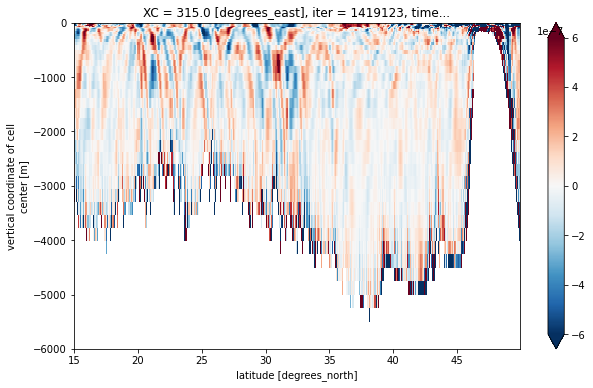

In [37]:
fig, ax = plt.subplots(figsize=(10,6))
delta.sel(XC=315,method='nearest').sel(YC=slice(15,50)).plot(ax=ax, vmax=6e-7, vmin=-6e-7, cmap='RdBu_r')

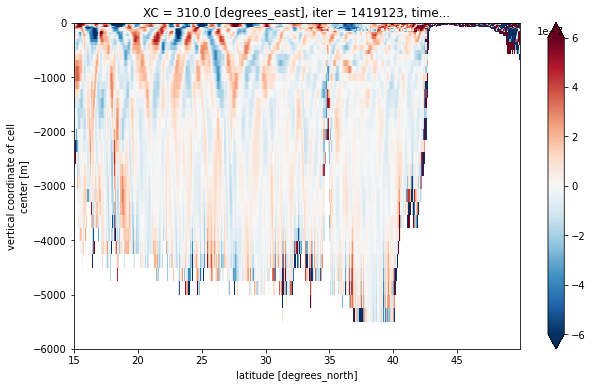

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
delta.sel(XC=310,method='nearest').sel(YC=slice(15,50)).plot(ax=ax, vmax=6e-7, vmin=-6e-7, cmap='RdBu_r')

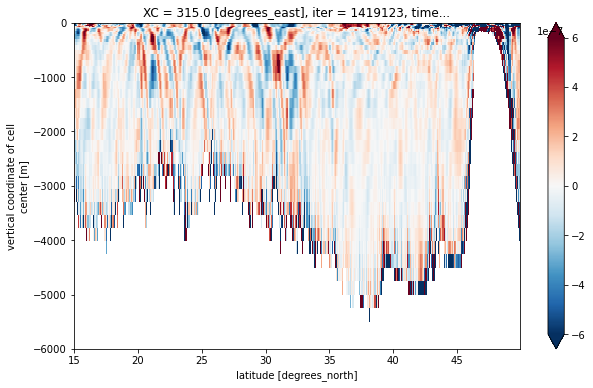

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
delta.sel(XC=315,method='nearest').sel(YC=slice(15,50)).plot(ax=ax, vmax=6e-7, vmin=-6e-7, cmap='RdBu_r')

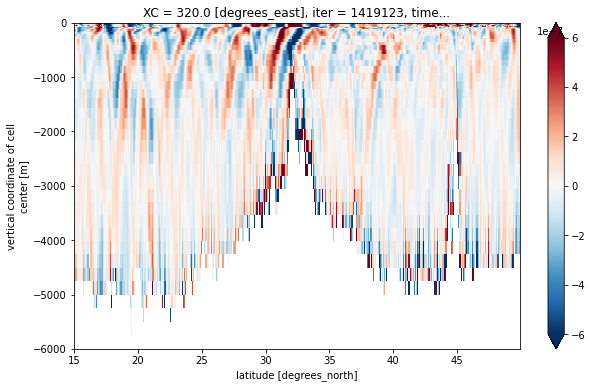

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
delta.sel(XC=320,method='nearest').sel(YC=slice(15,50)).plot(ax=ax, vmax=6e-7, vmin=-6e-7, cmap='RdBu_r')

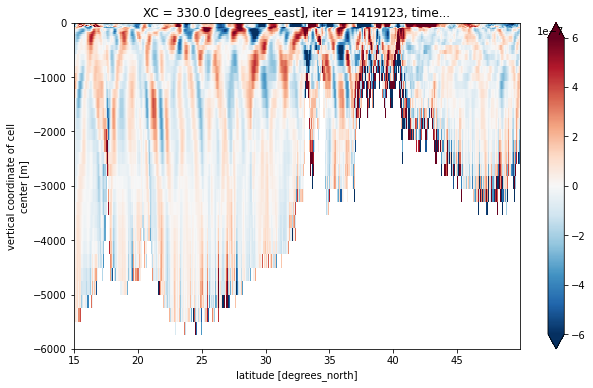

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
delta.sel(XC=330,method='nearest').sel(YC=slice(15,50)).plot(ax=ax, vmax=6e-7, vmin=-6e-7, cmap='RdBu_r')

In [22]:
ds5 = xr.open_mfdataset(op.join(spectre,'5Dave/run1967/Ensemble-mean/48members/15N-50N*.zarr')
                       )
ds5

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


,Array,Chunk
Bytes,5.28 GiB,3.51 MiB
Shape,"(73, 46, 422, 1000)","(1, 46, 100, 200)"
Count,3723 Tasks,1825 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.28 GiB,3.51 MiB
Shape,"(73, 46, 422, 1000)","(1, 46, 100, 200)"
Count,3723 Tasks,1825 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [24]:
grid5 = Grid(ds5, periodic=['X'])

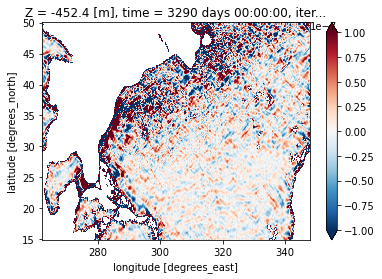

In [26]:
delta5 = (grid5.diff(ds5.UVEL.where(dsgrd.maskW!=0.)*dsgrd.dyG*dsgrd.drF,'X') 
          + grid5.diff(ds5.VVEL.where(dsgrd.maskS!=0.)*dsgrd.dxG*dsgrd.drF,'Y',boundary='extend')
         ) / dsgrd.rA/dsgrd.drF
delta5.isel(time=0,Z=18).plot(vmax=1e-7)

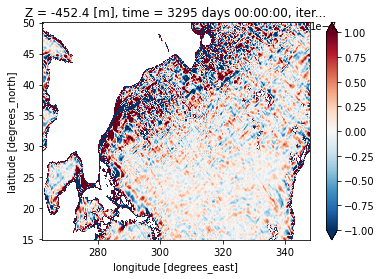

In [42]:
delta5.isel(time=1,Z=18).plot(vmax=1e-7)

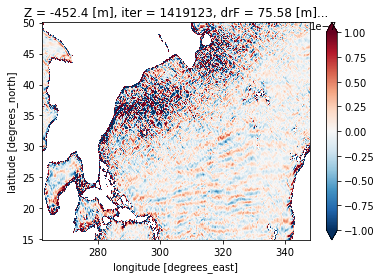

In [41]:
(delta5.isel(time=1,Z=18) - delta5.isel(time=0,Z=18)).plot(vmax=1e-7)

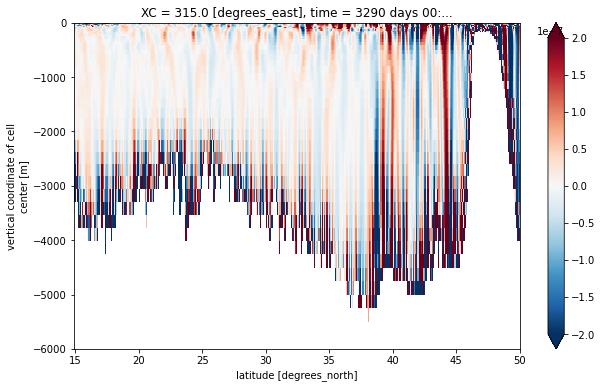

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
delta5.isel(time=0).sel(XC=315,method='nearest').plot(ax=ax, vmax=2e-7, vmin=-2e-7, cmap='RdBu_r')

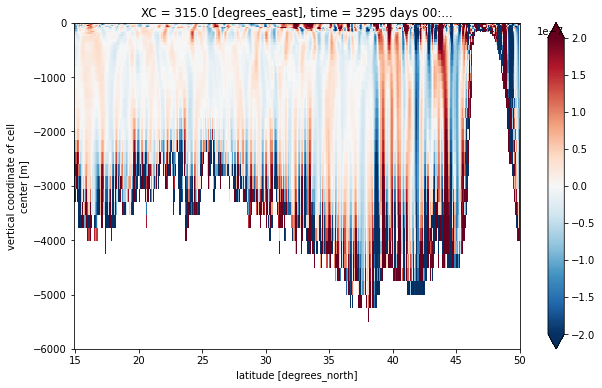

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
delta5.isel(time=1).sel(XC=315,method='nearest').plot(ax=ax, vmax=2e-7, vmin=-2e-7, cmap='RdBu_r')

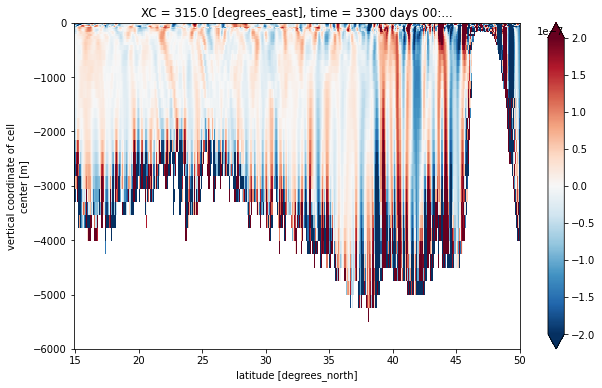

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
delta5.isel(time=2).sel(XC=315,method='nearest').plot(ax=ax, vmax=2e-7, vmin=-2e-7, cmap='RdBu_r')

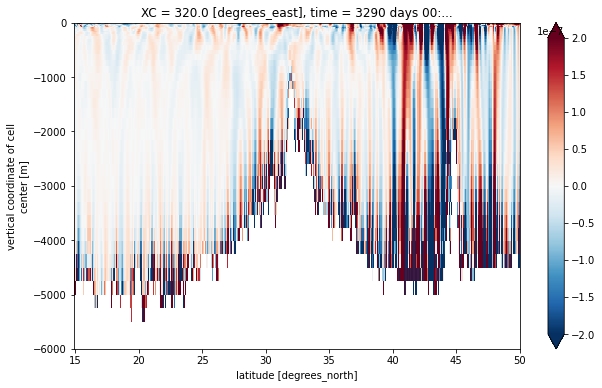

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
delta5.isel(time=0).sel(XC=320,method='nearest').plot(ax=ax, vmax=2e-7, vmin=-2e-7, cmap='RdBu_r')

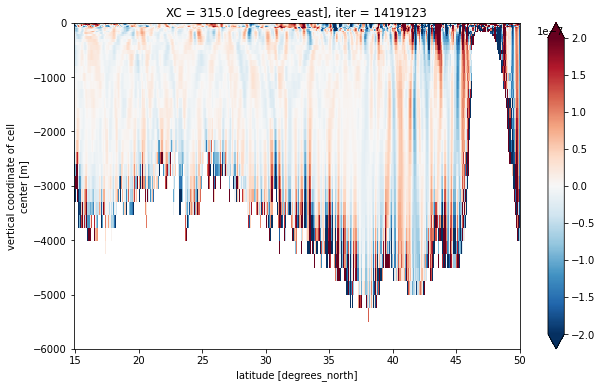

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
(delta5.isel(time=1).sel(XC=315,method='nearest') 
 - delta5.isel(time=0).sel(XC=315,method='nearest')).plot(ax=ax, vmax=2e-7, vmin=-2e-7, cmap='RdBu_r')